In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
from ultralytics import YOLO
import cv2
import os

# --------------------
# CONFIG
# --------------------
model_path = "/home/debasish/Documents/YOLOv8/weights/pose-weights/yolov8x-832.pt"
video_input = Path("/home/debasish/Documents/YOLOv8/videos/videos/image003.mp4")  # single file or folder
timestep = 30.0  # for velocity calculation
output_base_dir = Path("outputs/track")
output_base_dir.mkdir(parents=True, exist_ok=True)

video_extensions = [".mp4", ".avi", ".mov", ".mkv"]

# --------------------
# Collect video list
# --------------------
if video_input.is_file() and video_input.suffix.lower() in video_extensions:
    video_files = [video_input]
elif video_input.is_dir():
    video_files = []
    for ext in video_extensions:
        video_files.extend(video_input.glob(f"*{ext}"))
    video_files = sorted(video_files)
else:
    raise ValueError(f"Input must be a video file ({video_extensions}) or a folder containing such files")

if not video_files:
    raise FileNotFoundError(f"No supported video files found in {video_input}")

# --------------------
# Load YOLO model once
# --------------------
model = YOLO(model_path)

# --------------------
# Process each video
# --------------------
for video_path in video_files:
    print(f"\nProcessing video: {video_path.name}")

    # Create new run folder
    existing_runs = [d for d in output_base_dir.iterdir() if d.is_dir() and d.name.startswith("run")]
    run_num = len(existing_runs) + 1
    run_dir = output_base_dir / f"run{run_num}"
    run_dir.mkdir(parents=True, exist_ok=True)

    out_video_path = run_dir / f"{video_path.stem}_tracked.avi"
    out_csv_path = run_dir / f"{video_path.stem}_positions.csv"
    speed_csv_path = run_dir / f"{video_path.stem}_speed.csv"

    # --------------------
    # Tracking (video-level)
    # --------------------
    results = model.track(
        source=str(video_path), tracker="bytetrack.yaml", conf=0.8, persist=True, stream=True, verbose=True)

    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    writer = cv2.VideoWriter(str(out_video_path), fourcc, fps, (width, height))
    if not writer.isOpened():
        raise RuntimeError(f"Failed to open VideoWriter: {out_video_path}")

    # Tracking variables
    frame_num = 0
    frames, obj_ids, obj_clss, x, y, w, h = [], [], [], [], [], [], []
    trajectories, worm_colors = {}, {}

    for result in results:
        frame_num += 1
        ret, frame_img = cap.read()
        if not ret:
            break

        boxes = result.boxes
        if boxes is None or len(boxes) == 0 or boxes.cls is None or boxes.id is None or boxes.xywh is None:
            writer.write(frame_img)
            continue

        obj_cls = boxes.cls.cpu().numpy()
        obj_id = boxes.id.cpu().numpy().astype(int)
        xywh = boxes.xywh.cpu().numpy()

        for i, j, k in zip(obj_cls, obj_id, xywh):
            frames.append(frame_num)
            obj_clss.append(int(i))
            obj_ids.append(int(j))
            x.append(k[0]); y.append(k[1]); w.append(k[2]); h.append(k[3])

            # Update trajectory and color
            if j not in trajectories:
                trajectories[j] = []
                worm_colors[j] = tuple(np.random.randint(0, 255, size=3).tolist())
            trajectories[j].append((int(k[0]), int(k[1])))

        # Draw trajectories and IDs
        for worm_id, points in trajectories.items():
            color = worm_colors[worm_id]
            for pt_idx in range(1, len(points)):
                cv2.line(frame_img, points[pt_idx-1], points[pt_idx], color=color, thickness=2)
            if len(points) > 0:
                last_point = points[-1]
                cv2.putText(frame_img, str(worm_id), (last_point[0]+5, last_point[1]-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        writer.write(frame_img)

    cap.release()
    writer.release()
    print(f"Tracked video saved at: {out_video_path}")

    # --------------------
    # Save coordinates CSV
    # --------------------
    data = {"frame": frames, "obj_cls": obj_clss, "obj_id": obj_ids}
    bbox_out = {"x": x, "y": y, "w": w, "h": h}
    coords_df = pd.concat([pd.DataFrame(data), pd.DataFrame(bbox_out)], axis=1)
    coords_df.to_csv(out_csv_path, index=False)
    print(f"Coordinates CSV saved: {out_csv_path}")

    # --------------------
    # Compute distance & velocity
    # --------------------
    worm_ids = sorted(coords_df["obj_id"].unique())
    distances, velocities = [], []

    for worm_id in worm_ids:
        df_w = coords_df[coords_df["obj_id"] == worm_id]
        x_vals = df_w["x"].values
        y_vals = df_w["y"].values

        if len(x_vals) < 2:
            distances.append(0)
            velocities.append(0)
            continue

        dx = np.diff(x_vals)
        dy = np.diff(y_vals)
        distance = np.sum(np.sqrt(dx**2 + dy**2))
        velocity = distance / timestep

        distances.append(distance)
        velocities.append(velocity)

    # Save speed summary CSV
    track_outputs = pd.DataFrame({
        "worm_id": worm_ids,
        "Distance (pixels)": distances,
        "Velocity (pixels/s)": velocities
    })
    track_outputs.to_csv(speed_csv_path, index=False)
    print(f"Speed summary saved: {speed_csv_path}")


Processing video: image003.mp4

video 1/1 (frame 1/3045) /home/debasish/Documents/YOLOv8/videos/videos/image003.mp4: 480x832 1 worm, 19.7ms
video 1/1 (frame 2/3045) /home/debasish/Documents/YOLOv8/videos/videos/image003.mp4: 480x832 1 worm, 20.8ms
video 1/1 (frame 3/3045) /home/debasish/Documents/YOLOv8/videos/videos/image003.mp4: 480x832 1 worm, 20.4ms
video 1/1 (frame 4/3045) /home/debasish/Documents/YOLOv8/videos/videos/image003.mp4: 480x832 1 worm, 21.4ms
video 1/1 (frame 5/3045) /home/debasish/Documents/YOLOv8/videos/videos/image003.mp4: 480x832 1 worm, 21.1ms
video 1/1 (frame 6/3045) /home/debasish/Documents/YOLOv8/videos/videos/image003.mp4: 480x832 1 worm, 20.0ms
video 1/1 (frame 7/3045) /home/debasish/Documents/YOLOv8/videos/videos/image003.mp4: 480x832 1 worm, 21.1ms
video 1/1 (frame 8/3045) /home/debasish/Documents/YOLOv8/videos/videos/image003.mp4: 480x832 1 worm, 18.6ms
video 1/1 (frame 9/3045) /home/debasish/Documents/YOLOv8/videos/videos/image003.mp4: 480x832 1 worm, 19

KeyboardInterrupt: 

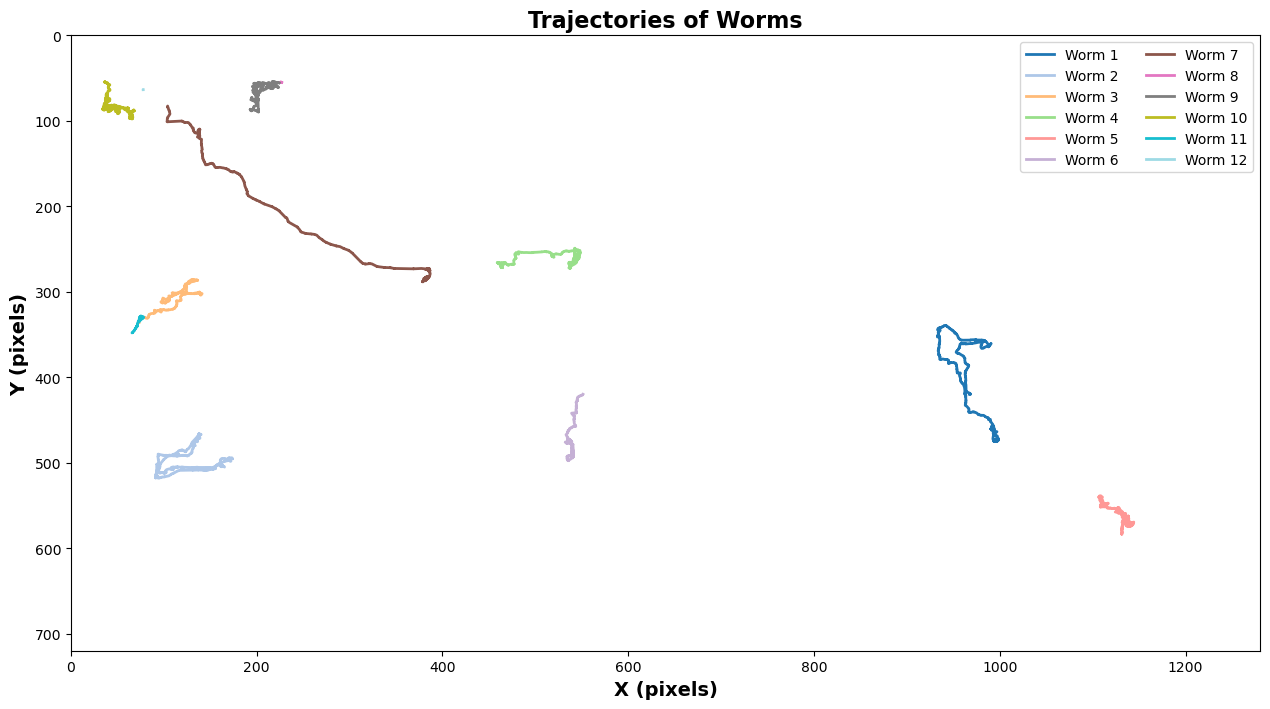

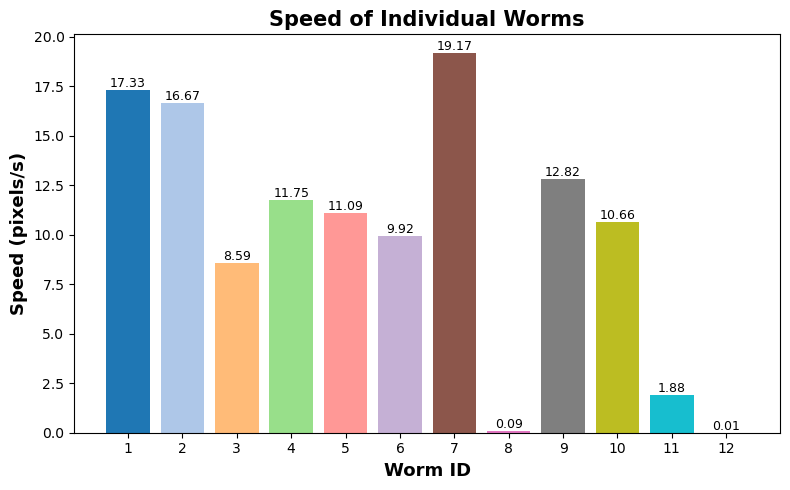

,worm_id,Distance (pixels),Velocity (pixels/s)
0,1,519.754456,17.325149
1,2,500.190918,16.673031
2,3,257.694885,8.589830
3,4,352.612061,11.753735
4,5,332.580750,11.086025
5,6,297.737793,9.924593
6,7,575.118164,19.170605
7,8,2.677187,0.089240
8,9,384.464478,12.815483
9,10,319.671143,10.655705


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- CONFIG ---
timestep = 30.0  # adjust this according to your experiment time

# --- Worm IDs and colors ---
worm_ids = sorted(coords_df["obj_id"].unique())
colors = plt.cm.tab20(np.linspace(0, 1, len(worm_ids)))  # distinct colors

distances = []
velocities = []

# --- Plot trajectories ---
plt.figure(figsize=(width/100, height/100))  # match video dimensions approximately

for idx, worm_id in enumerate(worm_ids):
    df_w = coords_df[coords_df["obj_id"] == worm_id]
    x = df_w["x"].values
    y = df_w["y"].values

    if len(x) < 2:  # skip worms with too few points
        distances.append(0)
        velocities.append(0)
        continue

    # Compute total distance and velocity
    dx = np.diff(x)
    dy = np.diff(y)
    distance = np.sum(np.sqrt(dx**2 + dy**2))
    velocity = distance / timestep

    distances.append(distance)
    velocities.append(velocity)

    # Plot trajectory
    plt.plot(x, y, color=colors[idx], linewidth=2, label=f"Worm {worm_id}")

plt.gca().invert_yaxis()  # match video coordinate system
plt.xlabel("X (pixels)", fontsize=14, weight='bold')
plt.ylabel("Y (pixels)", fontsize=14, weight='bold')
plt.xlim(0,width)
plt.ylim(height,0)
plt.title("Trajectories of Worms", fontsize=16, weight='bold')
plt.legend(ncols=2, fontsize=10)
plt.tight_layout()
plt.show()

# --- Plot speed bar graph ---
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(range(len(worm_ids)), velocities, color=colors[:len(worm_ids)])

# Place worm ids below each bar
ax.set_xticks([bar.get_x() + bar.get_width()/2 for bar in bars])
ax.set_xticklabels([str(w) for w in worm_ids], rotation=0)

ax.set_xlabel("Worm ID", fontsize=13, weight='bold')
ax.set_ylabel("Speed (pixels/s)", fontsize=13, weight='bold')
ax.set_title("Speed of Individual Worms", fontsize=15, weight='bold')

# Add speed values above each bar
for bar, vel in zip(bars, velocities):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f"{vel:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# --- Save summary as DataFrame ---
track_outputs = pd.DataFrame({
    "worm_id": worm_ids,
    "Distance (pixels)": distances,
    "Velocity (pixels/s)": velocities
})

track_outputs.to_csv(speed_csv_path, index=False)
track_outputs

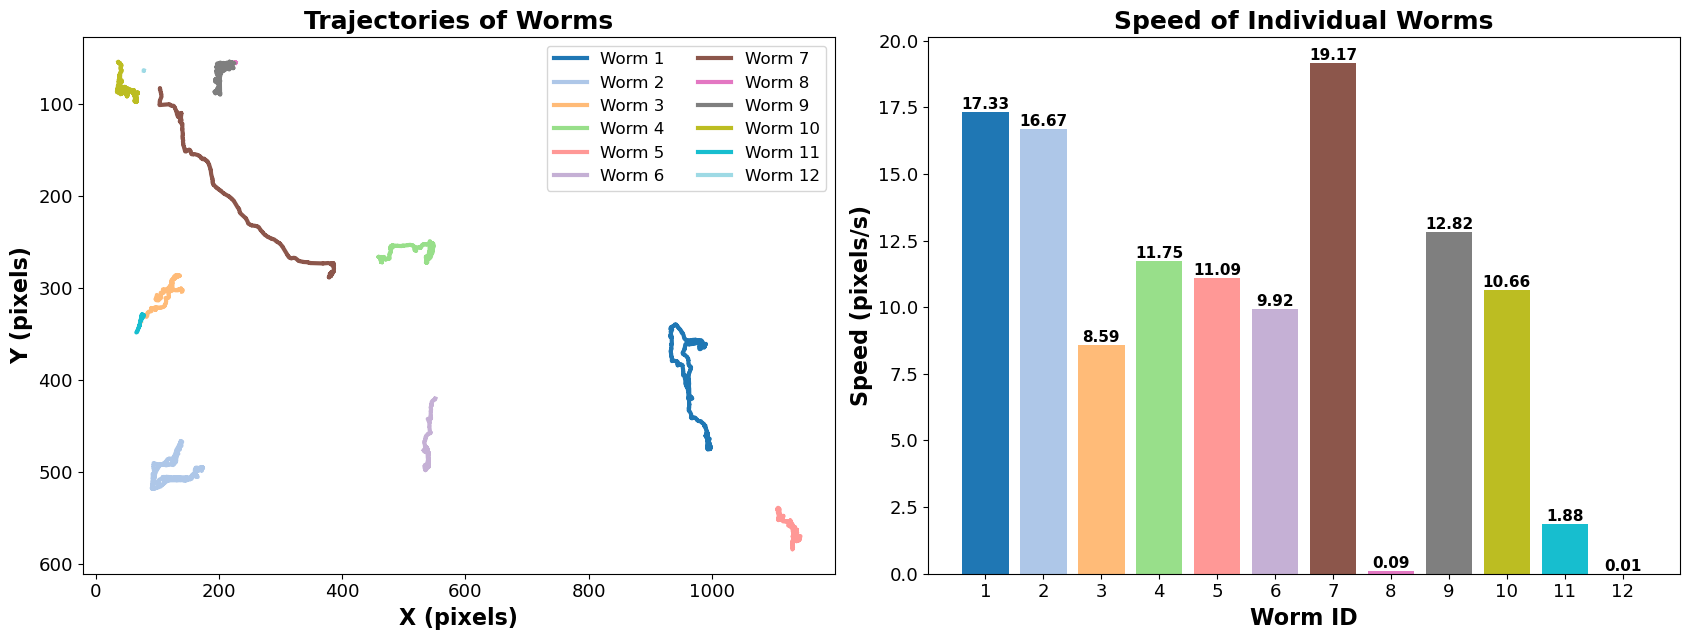

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- CONFIG ---
timestep = 30.0  # adjust if you want exact seconds based on FPS

# --- Worm IDs and colors ---
worm_ids = sorted(coords_df["obj_id"].unique())
colors = plt.cm.tab20(np.linspace(0, 1, len(worm_ids)))  # distinct colors

distances = []
velocities = []

# --- Create side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(17, 6.5))

# --- Trajectories plot ---
for idx, worm_id in enumerate(worm_ids):
    df_w = coords_df[coords_df["obj_id"] == worm_id]
    x = df_w["x"].values
    y = df_w["y"].values

    if len(x) < 2:  # skip worms with too few points
        distances.append(0)
        velocities.append(0)
        continue

    # Compute total distance and velocity
    dx = np.diff(x)
    dy = np.diff(y)
    distance = np.sum(np.sqrt(dx**2 + dy**2))
    velocity = distance / timestep

    distances.append(distance)
    velocities.append(velocity)

    # Plot trajectory
    axes[0].plot(x, y, color=colors[idx], linewidth=3, label=f"Worm {worm_id}")

axes[0].invert_yaxis()  # match video coordinate system
axes[0].set_xlabel("X (pixels)", fontsize=16, weight='bold')
axes[0].set_ylabel("Y (pixels)", fontsize=16, weight='bold')
axes[0].set_title("Trajectories of Worms", fontsize=18, weight='bold')
axes[0].legend(ncols=2, fontsize=12)
axes[0].tick_params(axis='both', labelsize=13)

# --- Speed bar graph ---
bars = axes[1].bar(range(len(worm_ids)), velocities, color=colors[:len(worm_ids)])

# Place worm ids below each bar
axes[1].set_xticks([bar.get_x() + bar.get_width()/2 for bar in bars])
axes[1].set_xticklabels([str(w) for w in worm_ids], rotation=0, fontsize=13)

axes[1].set_xlabel("Worm ID", fontsize=16, weight='bold')
axes[1].set_ylabel("Speed (pixels/s)", fontsize=16, weight='bold')
axes[1].set_title("Speed of Individual Worms", fontsize=18, weight='bold')
axes[1].tick_params(axis='both', labelsize=13)

# Add speed values above each bar
for bar, vel in zip(bars, velocities):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 f"{vel:.2f}", ha='center', va='bottom', fontsize=11, weight='bold')

plt.tight_layout()
plt.show()